In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
try:
    df = pd.read_csv('Mall_Customers.csv')
except FileNotFoundError:
    print("Error: Mall_Customers.csv not found. Please download it and place it in the project directory.")
    exit()

print("--- Dataset Head ---")
print(df.head())
print(f"\nShape: {df.shape}")
df.info()

print("\n--- Missing Values ---")
print(df.isnull().sum()) # This dataset is usually clean

print("\n--- Descriptive Statistics ---")
print(df.describe())

--- Dataset Head ---
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Shape: (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

--- Missing Value

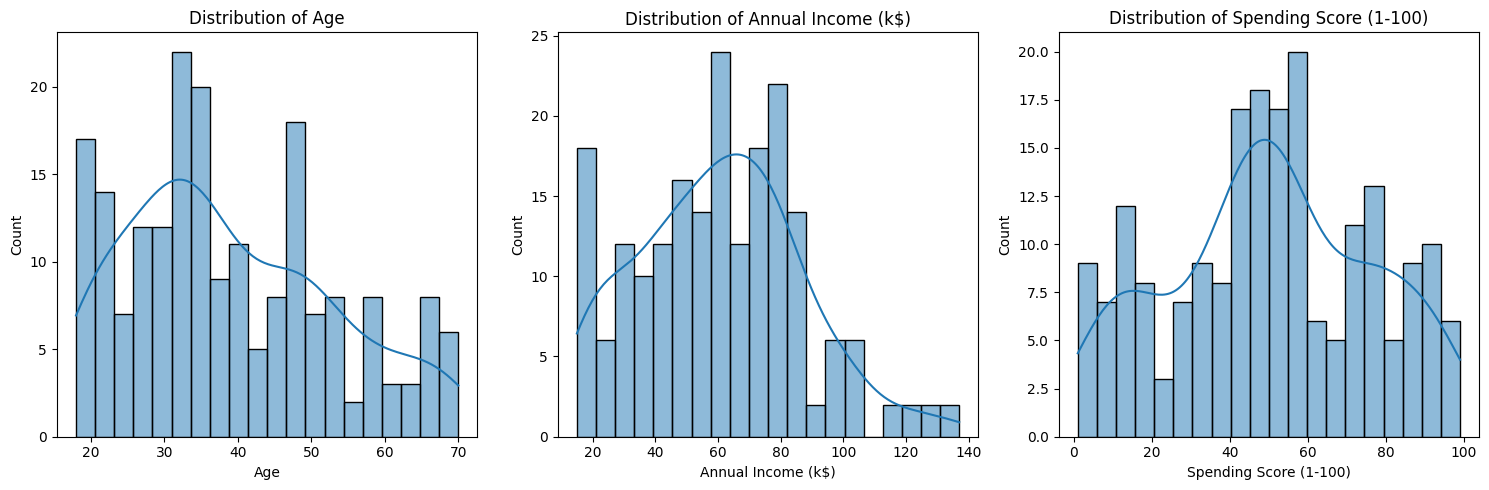

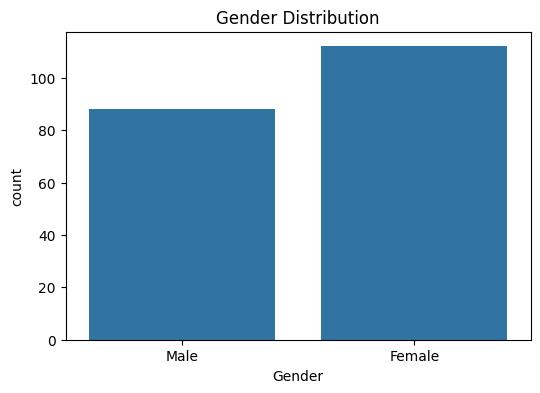

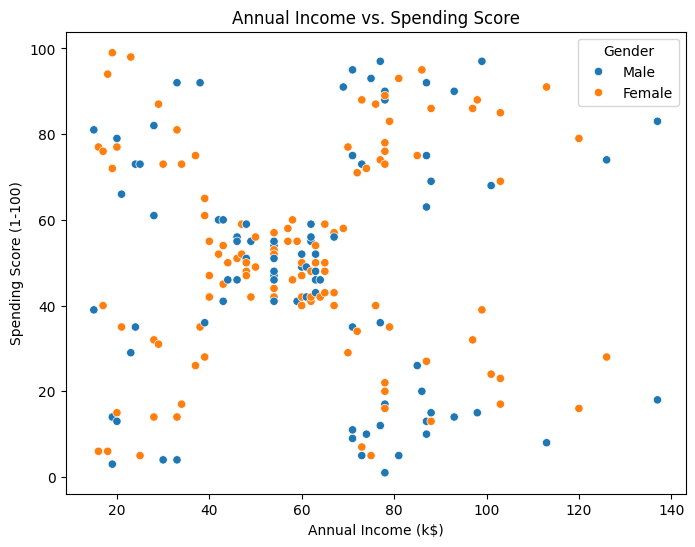

In [ ]:
# Drop CustomerID as it's not useful for segmentation
df_analysis = df.drop('CustomerID', axis=1)

# Visualize distributions of numerical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df_analysis[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show() # or plt.savefig('feature_distributions.png')

# Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', data=df_analysis)
plt.title('Gender Distribution')
plt.show() # or plt.savefig('gender_distribution.png')

# Scatter plot for Annual Income vs. Spending Score (common for this dataset)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_analysis, hue='Gender')
plt.title('Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show() # or plt.savefig('income_vs_spending_scatter.png')

# Pairplot for a quick overview of relationships
# sns.pairplot(df_analysis.drop('Gender', axis=1)) # Drop Gender for pairplot if not encoding it
# plt.suptitle('Pair Plot of Numerical Features', y=1.02)
# plt.show()

In [ ]:
# Select features for clustering
# For simplicity and clear visualization, let's start with Annual Income and Spending Score
X_features = df_analysis[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
# If you want to use Age as well:
# X_features = df_analysis[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].copy()

print("\n--- Features selected for clustering ---")
print(X_features.head())

# Feature Scaling: K-Means is sensitive to the scale of features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Convert scaled features back to a DataFrame (optional, but good for inspection)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)
print("\n--- Scaled Features ---")
print(X_scaled_df.head())


--- Features selected for clustering ---
   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40

--- Scaled Features ---
   Annual Income (k$)  Spending Score (1-100)
0           -1.738999               -0.434801
1           -1.738999                1.195704
2           -1.700830               -1.715913
3           -1.700830                1.040418
4           -1.662660               -0.395980


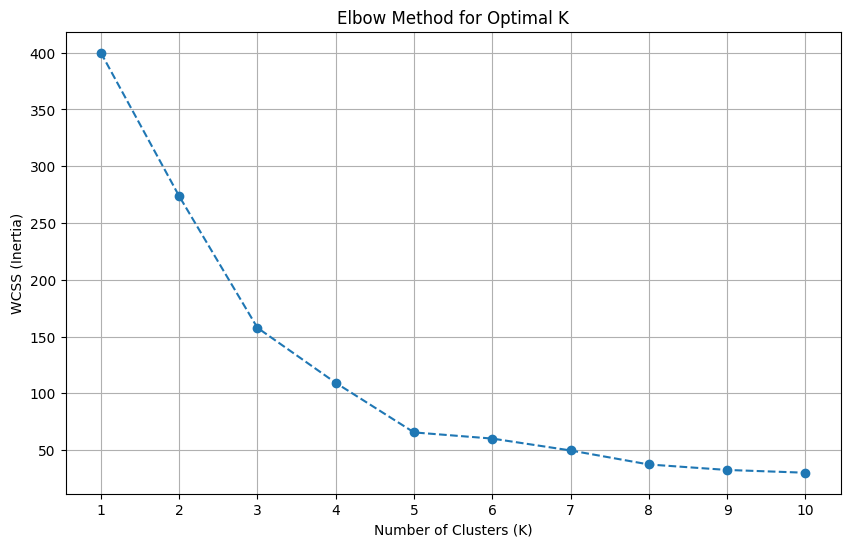


Chosen Optimal K: 5


In [ ]:
wcss = [] # Within-Cluster Sum of Squares
possible_k_values = range(1, 11) # Test K from 1 to 10

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    # 'n_init="auto"' is the default in newer sklearn versions and recommended
    # For older versions, you might use n_init=10
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(possible_k_values)
plt.grid(True)
plt.show() # or plt.savefig('elbow_method.png')

# Based on the elbow plot, choose the optimal K (often K=5 for this dataset with these features)
optimal_k = 5 # Adjust this based on your plot
print(f"\nChosen Optimal K: {optimal_k}")

In [ ]:
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add the cluster labels back to the original relevant DataFrame (or a copy)
df_clustered = X_features.copy() # Or df_analysis.copy() if you used more features
df_clustered['Cluster'] = cluster_labels
# If you want to add it to the full df_analysis (including Gender, Age):
# df_analysis['Cluster'] = cluster_labels # Ensure indices align if you subsetted X_features

print("\n--- Data with Cluster Labels (First 5 rows) ---")
print(df_clustered.head())
print("\n--- Cluster Distribution ---")
print(df_clustered['Cluster'].value_counts().sort_index())


--- Data with Cluster Labels (First 5 rows) ---
   Annual Income (k$)  Spending Score (1-100)  Cluster
0                  15                      39        4
1                  15                      81        2
2                  16                       6        4
3                  16                      77        2
4                  17                      40        4

--- Cluster Distribution ---
Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


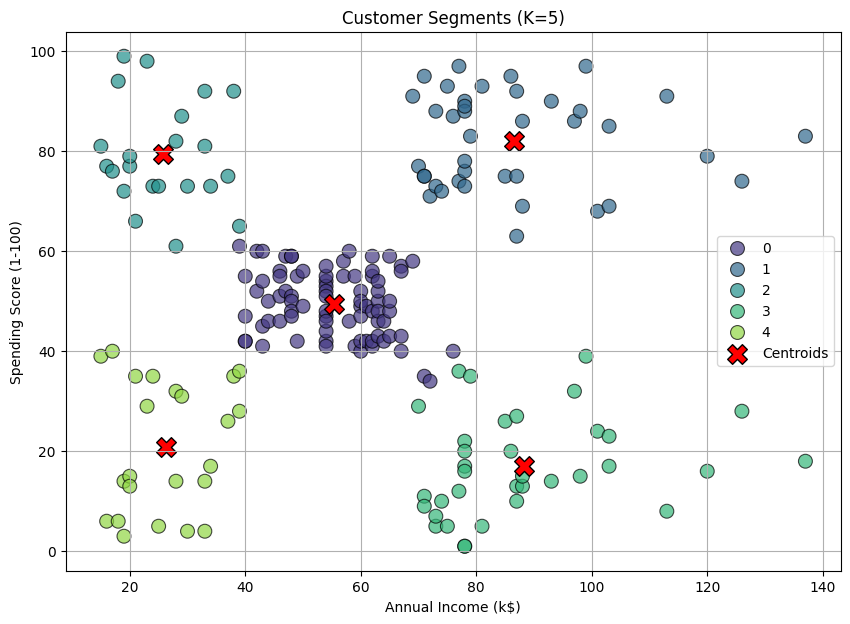

In [ ]:
plt.figure(figsize=(10, 7))
# Use the original (unscaled) features for plotting for better interpretability,
# but color by the cluster labels obtained from scaled data.
sns.scatterplot(x=X_features.iloc[:, 0], # e.g., 'Annual Income (k$)'
                y=X_features.iloc[:, 1], # e.g., 'Spending Score (1-100)'
                hue=df_clustered['Cluster'],
                palette=sns.color_palette('viridis', n_colors=optimal_k), # Use a distinct color palette
                s=100, alpha=0.7, edgecolor='k')

# Plot the centroids (use the scaled centroids and inverse_transform them to original scale)
centroids_scaled = kmeans_final.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids_scaled)

plt.scatter(centroids_original_scale[:, 0], centroids_original_scale[:, 1],
            marker='X', s=200, color='red', edgecolor='black', label='Centroids')

plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel(X_features.columns[0])
plt.ylabel(X_features.columns[1])
plt.legend()
plt.grid(True)
plt.show() # or plt.savefig('customer_segments.png')

In [ ]:
# Group by cluster and calculate mean values for features
cluster_analysis = df_clustered.groupby('Cluster').mean()
print("\n--- Cluster Analysis (Mean Feature Values per Cluster) ---")
print(cluster_analysis)

# Example Interpretation (you'll need to look at your `cluster_analysis` output):
# Cluster 0: Might be "Careful Spenders" (e.g., low income, low spending score)
# Cluster 1: Might be "Target Customers" (e.g., high income, high spending score)
# ... and so on. Describe each cluster based on its characteristics.


--- Cluster Analysis (Mean Feature Values per Cluster) ---
         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043
